In [38]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os,sys
sys.path.append("..")

from utils import *
from errors import *

from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
import cv2 as cv


In [39]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [40]:
# Loaded a set of images
root_dir = "../../data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)

ratio = 0.7
n = len(files) # Load maximum 20 images
n_train = int(n * ratio)
n_test = n - n_train

print("Loading " + str(n) + " images from images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images from groundtruth")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

#conversion to binary image values
for i in range(n):
    _, gt_imgs[i] = cv.threshold(gt_imgs[i], 0.5, 1, cv.THRESH_BINARY)

#creating train and test dataset
gt_imgs_tr = [gt_imgs[i] for i in range(n_train)]
gt_imgs_te = [gt_imgs[i] for i in range(n_train, n)]
imgs_tr = [imgs[i] for i in range(n_train)]
imgs_te = [imgs[i] for i in range(n_train, n)]

print("Size of initial train dataset : " + str(n_train))
print("Size of initial test dataset : " + str(n_test))

Loading 100 images from images
Loading 100 images from groundtruth
Size of initial train dataset : 70
Size of initial test dataset : 30


In [54]:
import imgaug as ia
import imgaug.augmenters as iaa

seq = iaa.Sequential([
    iaa.Fliplr(0.25), # horizontally flip 25% of the images
    iaa.Flipud(0.25), # vertically flip 25% of all images
    #iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 1))), #blur 50 % of the images
    iaa.Sometimes(0.9, iaa.Affine(rotate=(-70, 70), mode='reflect')),  # rotate by -45 to 45 degrees (affects segmaps)
    # Make some images brighter and some darker.
    # In 10% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    #iaa.Multiply((0.8, 1.2), per_channel=0.1),
    #iaa.GammaContrast((0.5, 1.5))
])

def augment_seg( img , seg  ):
    aug_det = seq.to_deterministic() 
    image_aug = aug_det.augment_image( img )
    segmap_aug = aug_det.augment_image(seg)
    #segmap = ia.SegmentationMapsOnImage( seg , shape=img.shape )
    #segmap_aug = aug_det.augment_segmentation_maps( segmap )
    #segmap_aug = 1*segmap_aug.get_arr()

    return image_aug , segmap_aug

[[0.      0.      0.      ... 1.      1.      1.     ]
 [0.      0.      0.      ... 1.      1.      1.     ]
 [0.      0.      0.      ... 1.      1.      1.     ]
 ...
 [0.      0.      0.      ... 0.      0.      0.     ]
 [0.      0.      0.      ... 0.09375 0.      0.     ]
 [0.      0.      0.      ... 0.96875 0.5     0.03125]]


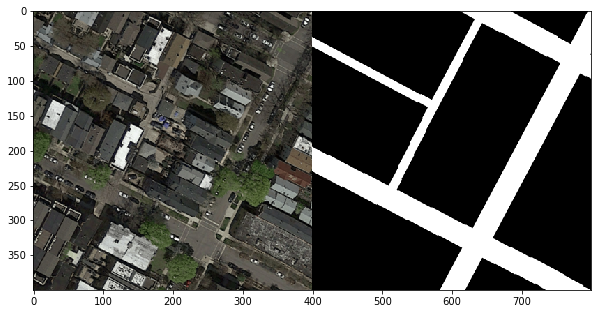

In [62]:
img_aug , gt_img_aug = augment_seg(imgs_tr[3], gt_imgs_tr[3])
cimg = concatenate_images(img_aug, gt_img_aug)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg)
print(gt_img_aug)
    

In [57]:
imgs_aug_tr = imgs_tr.copy()
imgs_aug_te = imgs_te.copy()
gt_imgs_aug_tr = gt_imgs_tr.copy()
gt_imgs_aug_te = gt_imgs_te.copy()

for i in range(n_train):
    #imgs_aug_tr.append(rgb2gray(imgs_tr[i]))
    #gt_imgs_aug_tr.append(gt_imgs_tr[i])
    for j in range(4):
        img_aug , gt_img_aug = augment_seg(imgs_tr[i], gt_imgs_tr[i])
        imgs_aug_tr.append(img_aug)
        gt_imgs_aug_tr.append(gt_img_aug)
        
for i in range(n_test):
    #imgs_aug_tr.append(rgb2gray(imgs_tr[i]))
    #gt_imgs_aug_tr.append(gt_imgs_tr[i])
    for j in range(4):
        img_aug , gt_img_aug = augment_seg(imgs_tr[i], gt_imgs_tr[i])
        imgs_aug_tr.append(img_aug)
        gt_imgs_aug_tr.append(gt_img_aug)


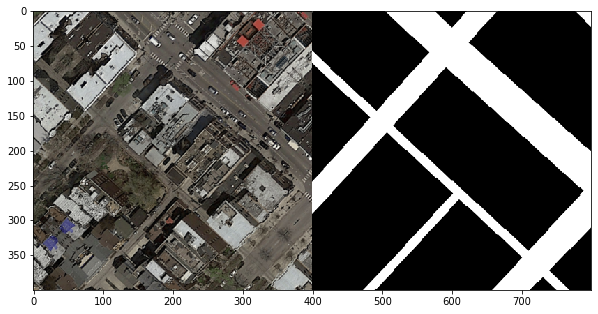

In [58]:
cimg = concatenate_images(imgs_aug_tr[-2], gt_imgs_aug_tr[-2])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg)

In [59]:
print(gt_imgs_aug_tr[-2].shape)

(400, 400)


In [14]:
img = gt_imgs_aug_tr[-2]
print(img[0:302,0:302].shape)

(302, 302)


(302, 302, 3)
(302, 302)


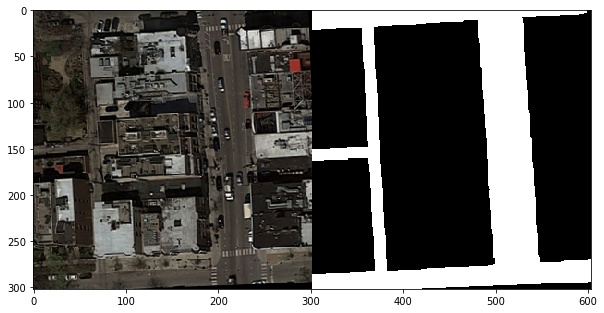

In [66]:
def __random_corner__(window_size, img, seg):
    shape = img.shape # x,y
    corner = np.random.choice(4)

    x_from = int(corner/2)*(shape[0]-window_size)
    y_from = int(corner%2)*(shape[1]-window_size)
    x_to = x_from+window_size
    y_to = y_from+window_size
    return img[x_from:x_to, y_from:y_to], seg[x_from:x_to, y_from:y_to]

i,j = __random_corner__(302, imgs_aug_tr[-2], gt_imgs_aug_tr[-2])
print(i.shape)
print(j.shape)
cimg = concatenate_images(i, j)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg)